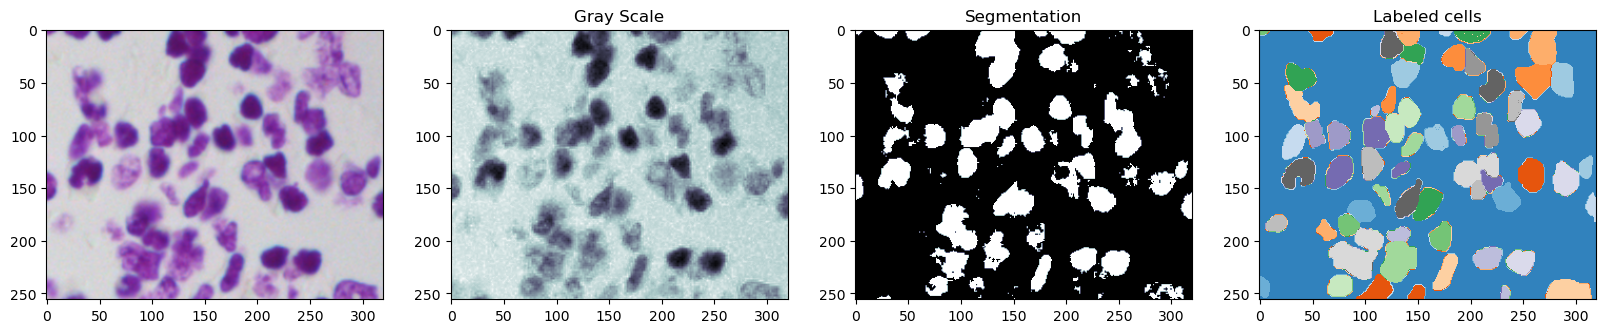

In [1]:
from skimage.filters import threshold_otsu
from skimage.color import rgb2hsv
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
%matplotlib inline

rgb_img = imread("../Lecture-03/figures/dsb_sample/slide.png")[:, :, :3]
gt_labs = imread("../Lecture-03/figures/dsb_sample/labels.png")
bw_img = rgb2hsv(rgb_img)[:, :, 2]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6), dpi=100)
ax1.imshow(rgb_img, cmap='bone')
ax2.imshow(bw_img, cmap='bone'),ax2.set_title('Gray Scale')
ax3.imshow(bw_img < threshold_otsu(bw_img), cmap='bone'), ax3.set_title('Segmentation')
ax4.imshow(gt_labs, cmap='tab20c'),ax4.set_title('Labeled cells');

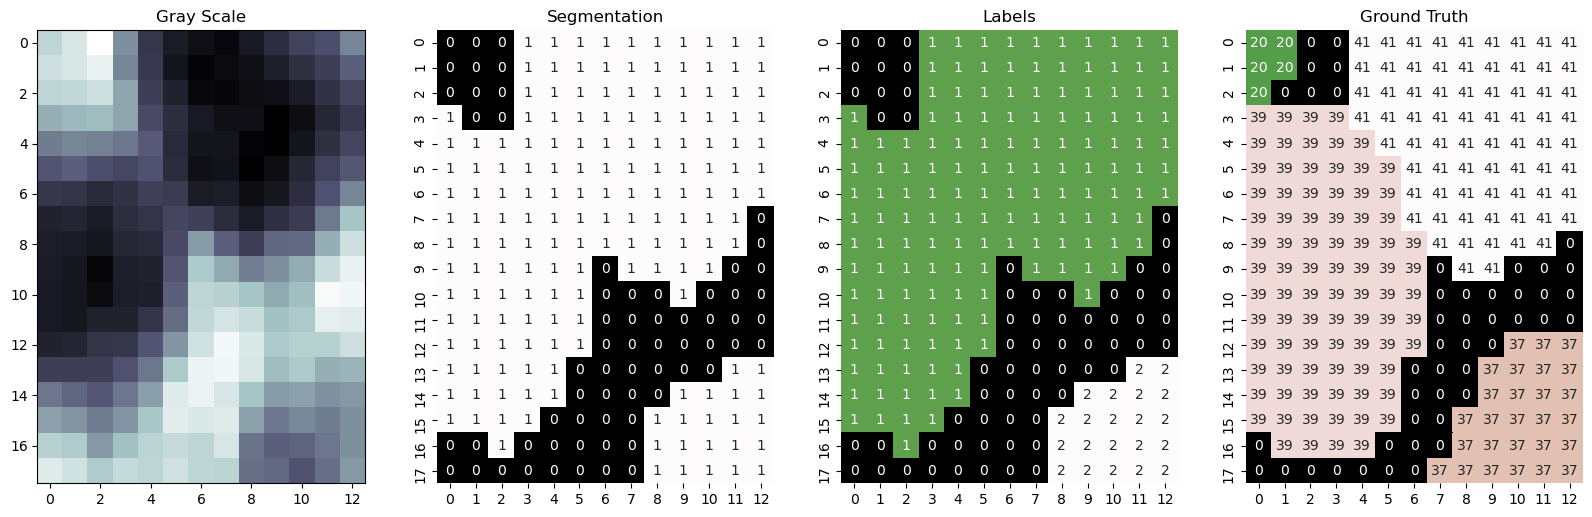

In [30]:
from skimage.morphology import label
import seaborn as sns
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6), dpi=100)
bw_roi = bw_img[75:110:2, 125:150:2]
ax1.imshow(bw_roi, cmap='bone'); ax1.set_title('Gray Scale')
bw_roi_seg = bw_roi < threshold_otsu(bw_img)
sns.heatmap(bw_roi_seg, annot=True, fmt="d",
            ax=ax2, cbar=False, cmap='gist_earth'); ax2.set_title('Segmentation');  
bw_roi_label = label(bw_roi_seg)
sns.heatmap(bw_roi_label, annot=True, fmt="d",
            ax=ax3, cbar=False, cmap='gist_earth'); ax3.set_title('Labels')
sns.heatmap(gt_labs[75:110:2, 125:150:2], annot=True,
            fmt="d", ax=ax4, cbar=False, cmap='gist_earth'); ax4.set_title('Ground Truth');

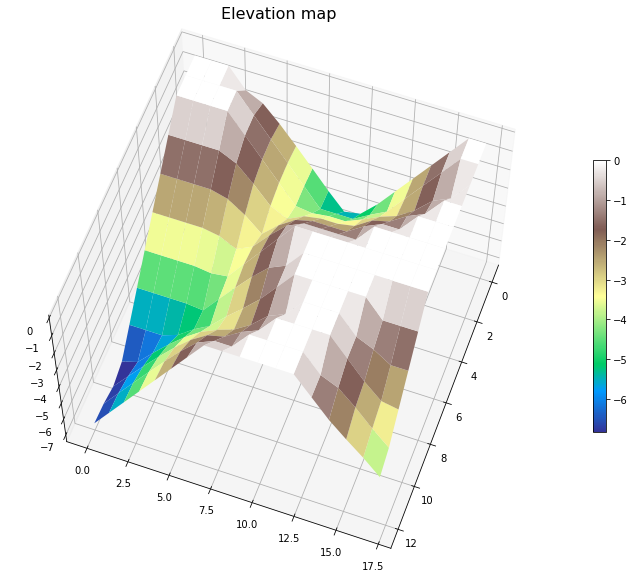

In [31]:
from scipy.ndimage import distance_transform_edt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')
bw_roi_dmap = distance_transform_edt(bw_roi_seg) # The distance map needed for the segmentation

# Plot the surface.
t_xx, t_yy = np.meshgrid(np.arange(bw_roi_dmap.shape[1]),np.arange(bw_roi_dmap.shape[0]))
surf = ax.plot_surface(t_xx, t_yy,-1*bw_roi_dmap, cmap="terrain",linewidth=0.25, antialiased=True)

# Customize the z axis.
ax.view_init(60, 20)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5); ax.set_title('Elevation map',fontsize=16);

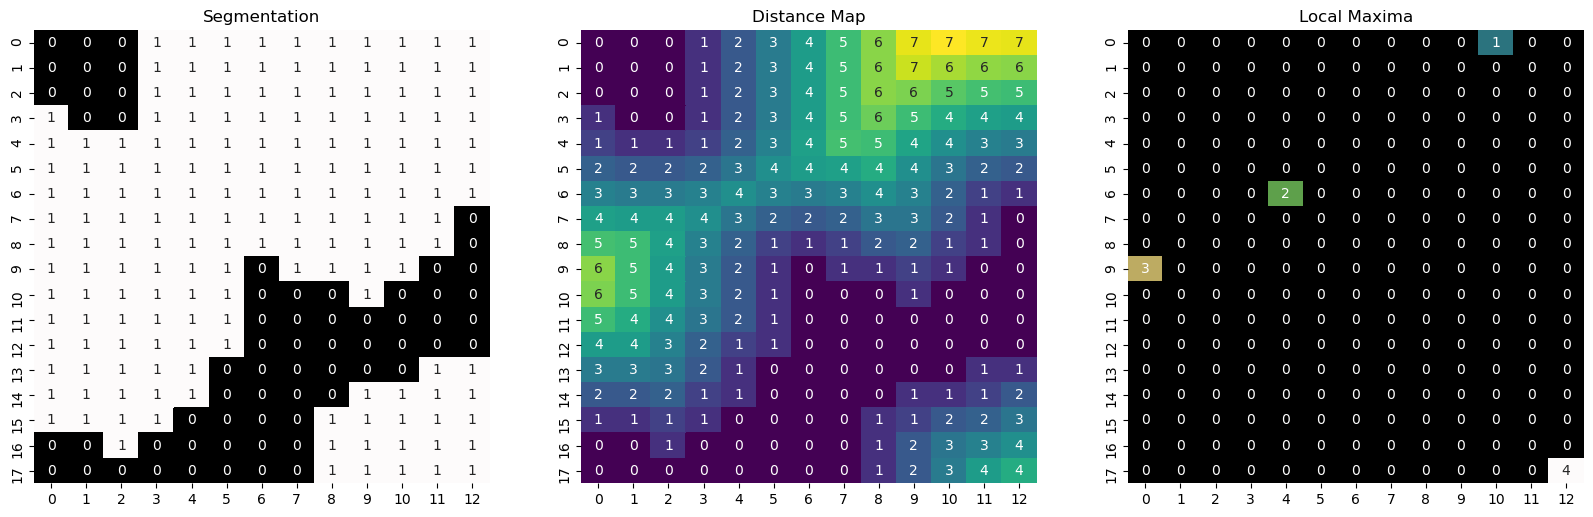

In [32]:
from skimage.feature import peak_local_max
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6), dpi=100)
sns.heatmap(bw_roi_seg, annot=True, fmt="d",
            ax=ax1, cbar=False, cmap='gist_earth'); ax1.set_title('Segmentation')
sns.heatmap(bw_roi_dmap, annot=True, fmt="1.0f",ax=ax2, cbar=False, cmap='viridis'),ax2.set_title('Distance Map');
roi_local_maxi = peak_local_max(bw_roi_dmap, indices=False, footprint=np.ones((3, 3)),
                                labels=bw_roi_seg, exclude_border=False)
labeled_maxi = label(roi_local_maxi)

sns.heatmap(labeled_maxi, annot=True, fmt="1.0f", ax=ax3, cbar=False, cmap='gist_earth'),ax3.set_title('Local Maxima');

In [151]:
from skimage.segmentation import watershed 
from skimage.morphology import expand_labels

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6), dpi=100)
sns.heatmap(labeled_maxi, annot=True, fmt="1.0f",
            ax=ax1, cbar=False, cmap='gist_earth'); ax1.set_title('Local Maxima')

ws_labels = watershed(-bw_roi_dmap, labeled_maxi, mask=bw_roi_seg)

sns.heatmap(ws_labels, annot=True, fmt="d",
            ax=ax2, cbar=False, cmap='gist_earth'); ax2.set_title('Watershed')

sns.heatmap(gt_labs[75:110:2, 125:150:2], annot=True,
            fmt="d", ax=ax3, cbar=False, cmap='gist_earth'); ax3.set_title('Ground Truth');

ImportError: cannot import name 'expand_labels' from 'skimage.morphology' (/Users/kaestner/opt/anaconda3/lib/python3.7/site-packages/skimage/morphology/__init__.py)

In [153]:
import skimage
print(skimage.__version__)

0.17.2


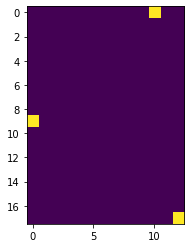

In [72]:
from skimage.morphology import h_maxima

h=2
marker2=h_maxima(bw_roi_dmap,h=h)
plt.imshow(marker2)

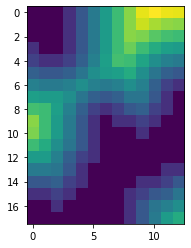

In [48]:
plt.imshow(bw_roi_dmap)

## Minimpose

$$R^{\varepsilon}_{(f+1)\hat{}f_m}(f_m)$$

with 

$$f_m(p)=\begin{cases} 0 &\mbox{if } p \mbox{ belongs to a marker}\\
t_{max} & \mbox{otherwise} \end{cases}$$

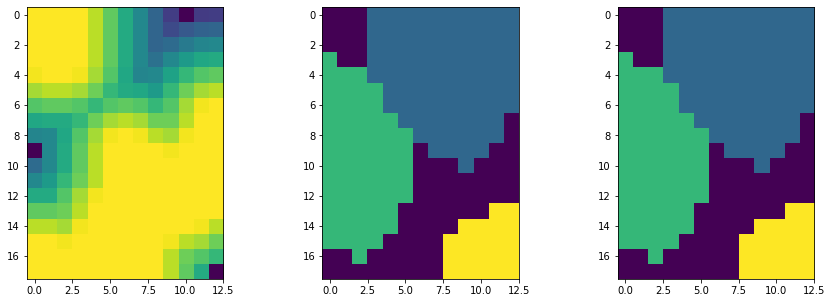

In [155]:
import skimage.morphology.greyreconstruct as gr

def min_impose(dimg,markers) :
    fm=markers.copy()
    fm[markers != 0] = 0
    fm[markers == 0] = dimg.max()
    dimg2 = np.minimum(fm,dimg+1)
    res   = gr.reconstruction(fm,dimg2,method='erosion')
    
    return res
    

d = bw_roi_dmap.max()-bw_roi_dmap
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(min_impose(d,marker3))
ws0 = watershed(-bw_roi_dmap, label(marker3), mask=bw_roi_seg)
m3=label(marker3)
ws  = watershed(min_impose(d,marker3),m3,mask=bw_roi_seg)
ax[1].imshow(ws0)
ax[2].imshow(ws)

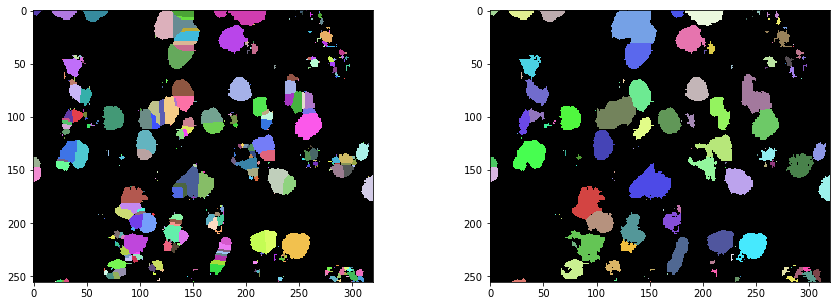

In [91]:
from matplotlib.colors import ListedColormap
seg=bw_img < threshold_otsu(bw_img)

dmap = distance_transform_edt(seg)

m0  = label(peak_local_max(dmap, indices=False, footprint=np.ones((3, 3)), labels=seg, exclude_border=False))
ws0 = watershed(-dmap, m0, mask=seg)
                
fig,ax=plt.subplots(1,2,figsize=(15,5))

clist=np.random.uniform(low=0.2,size=[m0.max(),3]); clist[0,:]=0;
wildmap = ListedColormap(clist)
                
ax[0].imshow(ws0,cmap=wildmap,interpolation='None')

h=1
localmax = h_maxima(dmap,h)
rdmap    = dmap.max()-dmap
marker   = label(localmax)

ws1 = watershed(min_impose(rdmap,marker),marker,mask=seg)
clist=np.random.uniform(low=0.2,size=[marker.max(),3]); clist[0,:]=0;
wildmap = ListedColormap(clist)

ax[1].imshow(ws1,cmap=wildmap,interpolation='None')



In [84]:
expand_labels

(684, 2)

# Colormaps

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import hsv2rgb


In [139]:
N=marker.max()

def goldenCM(N,increment=1.0,s=0.5,v=0.7,bg=0) :
    phi= 0.5*(np.sqrt(5)-1)
    
    hsv = np.zeros([N,3]);
    hsv[:, 0] = [increment*phi*np.linspace(0,N-1,N)-np.floor(increment*phi*np.linspace(0,N-1,N))
    hsv[:, 1] = s
    hsv[:, 2] = v
    rgb = hsv2rgb(hsv)
    if bg is not None : rgb[0,:]=bg    
    cm = ListedColormap(rgb) 
    return cm

def randomCM(N, low=0.2, high=1.0,seed=42, bg=0) :
    np.random.seed(seed=seed)
    clist=np.random.uniform(low=low,high=high,size=[marker.max(),3]); 
    if bg is not None : clist[0,:]=bg;
        
    rmap = ListedColormap(clist)
    
    return rmap

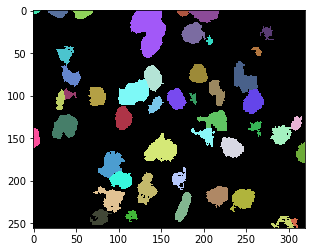

In [145]:
plt.imshow(ws,cmap=randomCM(marker.max(),bg=0),interpolation='none');

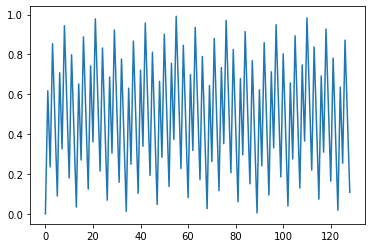

In [141]:
plt.plot(hsv[:,0])